In [1]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import os
import datetime as dt
import re

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from yellowbrick.regressor import ResidualsPlot

In [2]:
# import csv
wiki_feat = pd.read_csv('../../WebScraper/wikiarticles.csv')
wiki_feat = wiki_feat.set_index('article_name') #set article name as index
wiki_feat['date_article_creation'] = wiki_feat['date_article_creation'].str[7:] #strip time

In [3]:
# clean up column 'date_article_creation' and make 'days_since_creation'
wiki_feat['date_article_creation']= pd.to_datetime(wiki_feat['date_article_creation'], errors='coerce')
today = pd.to_datetime(dt.date.today())
wiki_feat['days_since_creation'] = (today - wiki_feat['date_article_creation']) / pd.Timedelta(1, 'D') # convert timedelta object to pure day by dividing by 1 d

Below module goes into individual html files, loads file into BeatifulSoup, and extracts 9 features. It initially adds them as lists, which is then added to the dataframe 'wiki_feat' at the end. There is 'exec_counter' right before the for loop and a print statement at the end to print how many for loops it has iterated.

In [ ]:
lang_nums = [] 
ref_counts = [] 
body_text_lens = [] 
main_article_num = [] 
see_also_num = [] 
further_info_num = [] 
table_text_lens = [] 
sports = []
wiki_link_nums = [] 

exec_counter = 0
for article in wiki_feat.index:
    filename = "../../wikiarticles/" + article + ".html"
    html_handle = open(filename)
    html_text = html_handle.read()
    soup = BeautifulSoup(html_text, 'lxml')

    # filling list for target
    lang_section = soup.find("nav", {"id":"p-lang"})
    lang_num = len(lang_section.find_all('li'))
    lang_nums.append(lang_num)

    # filling list for feature 2, extract number of references from html
    try:
        ref_count = len(soup.find('ol', class_='references').find_all('li'))
    except AttributeError: #when there are no references
        ref_count = 0
    ref_counts.append(ref_count)
    
    # use for finding features 3-7
    body_text = soup.find("div", {"id":"mw-content-text"}).text

    # filling list for feature 3, extract length of body text
    len_body_text = len(body_text)
    body_text_lens.append(len_body_text)

    # find all occurances of "Main article:" or "Main articles:" (feat 4)
    main_article_count = 0
    for main_article in re.finditer('Main article:', body_text):
        main_article_count += 1
    for main_articles in re.finditer('Main articles:', body_text):
        main_article_count += 1
    main_article_num.append(main_article_count)

    # find all occurances of "See also:" (feat 5)
    see_also_count = 0
    for see_also in re.finditer('See also:', body_text):
        see_also_count += 1
    see_also_num.append(see_also_count)

    # find all occurnaces of "Further information:" (feat 6)
    further_info_count = 0
    for further_info in re.finditer('Further info:', body_text):
        further_info_count += 1
    further_info_num.append(further_info_count)

    # find all text within any tables, and find length (feat 8)
    table_list = soup.find_all("table")
    table_text_len = 0
    for element in table_list:
        table_text_len += len(element.text)
    table_text_lens.append(table_text_len)

    # is this article sports? (feat 9)
    category_text = soup.find("div", {"id":"mw-normal-catlinks"}).text
    sport_list = ['Baseball', 'baseball', 'Basketball', 'basketball', 'Football', 'football', 'Soccer', 'soccer', 'Hockey', 'hockey', 'Volleyball', 'volleyball', 'Tennis', 'tennis', 'Cricket', 'cricket', 'Golf', 'golf']
    sports_bool = 0
    for sport in sport_list:
        if re.findall(sport, category_text) != []:
            sports_bool = 1
    sports.append(sports_bool)

    # number of links to other wiki articles (feat 10)
    body_html = soup.find("div", {"id":"mw-content-text"})
    for div in body_html.find_all("div", {'class':'navbox'}): # delete all navboxes
        div.decompose()
    for table in body_html.find_all("table"): # delete all tables
        table.decompose()
    num_wiki_links = 0
    for link in soup.find_all('a', attrs={'href': re.compile("/wiki/")}):
        num_wiki_links += 1
    for link in soup.find_all('a', attrs={'href': re.compile("/w/index.php")}):
        num_wiki_links += 1
    wiki_link_nums.append(num_wiki_links)
    
    exec_counter += 1
    print(exec_counter)

wiki_feat['languages'] = lang_nums
wiki_feat['references'] = ref_counts
wiki_feat['text_length'] = body_text_lens
wiki_feat['main_article_num'] = main_article_num
wiki_feat['see_also_num'] = see_also_num
wiki_feat['further_info_num'] = further_info_num
wiki_feat['table_text_len'] = table_text_lens
wiki_feat['sports'] = sports
wiki_feat['wiki_link_num'] = wiki_link_nums

In [6]:
wiki_feat.dropna(inplace=True)
wiki_feat.drop(columns = ['further_info_num'], inplace=True, errors='ignore')

In [ ]:
# Save dataframe as csv to be used for other models
wiki_feat.to_csv(r'wiki_10feat.csv')

Some additional cleaning up below, including changing column order, and deleting 6 entries that were severe model outliers in previous iterations

In [7]:
wiki_feat.drop(columns = ['date_article_creation'], inplace=True, errors='ignore')
wiki_feat_columns = ['languages', 'references', 'text_length', 'main_article_num', 'see_also_num', 'table_text_len', 'sports', 'wiki_link_num', 'days_since_creation']
wiki_feat = wiki_feat.reindex(columns=wiki_feat_columns)
wiki_feat.drop(['1858', 'Ice','Dysprosium','Eucalyptus','.uy','2000s in music'], inplace=True, errors='ignore')

In [8]:
#normalize all features except languages
normalized_wiki_feat = (wiki_feat - wiki_feat.mean()) / wiki_feat.std()
normalized_wiki_feat['languages'] = wiki_feat['languages']

In [9]:
normalized_wiki_feat.sort_values(by='languages',ascending=False).head(10)

,languages,references,text_length,main_article_num,see_also_num,table_text_len,sports,wiki_link_num,days_since_creation
article_name,,,,,,,,,
Lubusz Voivodeship,75,-0.073422,0.418939,-0.111103,-0.120394,0.075604,-0.348228,3.038098,1.104362
Jeans,73,-0.352220,2.615714,-0.111103,2.269721,0.266899,-0.348228,4.397183,0.779941
Gamete,69,-0.003722,0.170986,-0.111103,-0.120394,-0.140516,-0.348228,1.646653,0.920059
Temple in Jerusalem,66,2.435764,3.761825,6.114674,2.269721,1.473762,-0.348228,5.820987,-1.940423
Rosalyn Sussman Yalow,65,2.087266,3.902096,-0.111103,-0.120394,7.540671,-0.348228,2.617428,0.652034
Republic of Genoa,64,-0.352220,3.776274,-0.111103,-0.120394,1.249265,-0.348228,6.985917,0.853779
Pope Nicholas II,63,-0.212821,1.376370,0.926526,9.440066,2.395663,-0.348228,1.856988,-0.102622
Gerard Butler,61,3.132760,1.632127,0.926526,-0.120394,0.372903,-0.348228,3.830897,-0.615997
Flame,60,0.623574,1.115549,0.926526,2.269721,-0.137470,-0.348228,3.361689,-1.304373


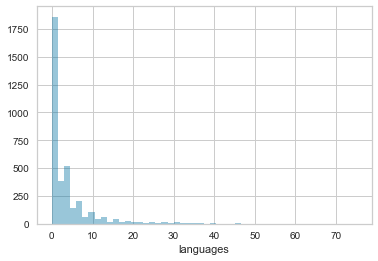

In [10]:
# plots distribution of the y variable. Very much skewed to the left.

%matplotlib inline
sns.distplot(wiki_feat['languages'], kde=False)

Modeling starting below

In [11]:
# Set X as all the features. Set y as the target.
X = normalized_wiki_feat.loc[:, 'references':'days_since_creation']
y = normalized_wiki_feat['languages']

Next two cells testing regular linear regression

In [12]:
lr_full = LinearRegression()
lr_full.fit(X, y)
lr_full.score(X, y)

0.1941923745848937

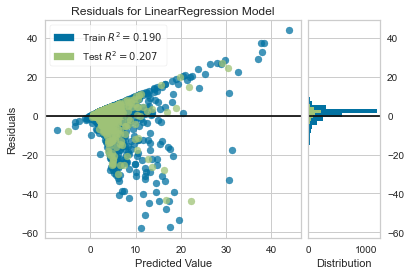

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)
model = LinearRegression()
visualizer = ResidualsPlot(model)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure

Next two cells testing linear regression with polynomial features

In [14]:
p = PolynomialFeatures()
X_poly = p.fit_transform(X)

lr_full = LinearRegression()
lr_full.fit(X_poly, y)
lr_full.score(X_poly, y)

0.31079902571754725

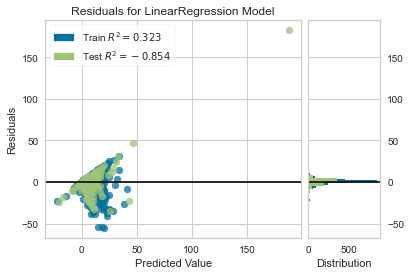

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state = 42)
model = LinearRegression()
visualizer = ResidualsPlot(model)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure

Next two cells testing polynomial features with LassoCV, and then extracting which features have been reduced to zero with the algorithm

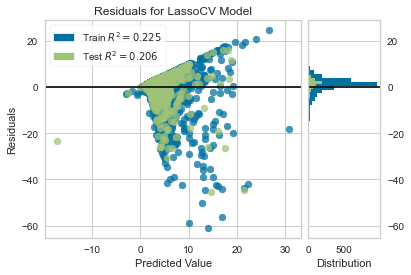

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state = 42)
model = LassoCV()
visualizer = ResidualsPlot(model)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure

In [17]:
coef_list = list(zip(p.get_feature_names(X.columns), visualizer.coef_))
coef_list_nonz = [tuple for tuple in coef_list if tuple[1] != 0]
coef_list_nonz

[('wiki_link_num', 4.033591405900926),
 ('references^2', -0.032953525814871286),
 ('references wiki_link_num', 0.0867935365500016),
 ('text_length^2', -0.029165635069671753),
 ('main_article_num^2', -0.027103772066585197),
 ('main_article_num table_text_len', -0.03934467559373422),
 ('see_also_num table_text_len', -0.008502591271310098),
 ('see_also_num sports', -0.07804114101792674),
 ('table_text_len^2', -0.006081783705094842),
 ('table_text_len wiki_link_num', 0.45699242931225875),
 ('sports^2', -0.013991573967848142),
 ('wiki_link_num^2', -0.2786179725852565)]